# Расчет RR n-го дня по когортам по дате регистрации

In [1]:
import pandas as pd
from datetime import datetime
import seaborn as sns
sns.set(rc={'figure.figsize':(13,11)})

import warnings
warnings.filterwarnings('ignore')

import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [2]:
auth_data = pd.read_csv("/mnt/HC_Volume_18315164/home-jupyter/jupyter-an-bogdanov/shared/problem1-auth_data.csv", sep=";")

In [3]:
auth_data.head(10)

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2
5,934372615,2
6,934662633,2
7,935002586,2
8,935141232,2
9,935682752,2


In [4]:
auth_data.shape

(9601013, 2)

In [5]:
reg_data = pd.read_csv("/mnt/HC_Volume_18315164/home-jupyter/jupyter-an-bogdanov/shared/problem1-reg_data.csv", sep=";")

In [6]:
reg_data.head(10)

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5
5,977206495,6
6,984222671,7
7,990407778,8
8,995943765,9
9,1000951674,10


In [7]:
reg_data.shape

(1000000, 2)

In [8]:
# требуется предобрабоать дату
auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

In [9]:
# в данных отсутствуют пустые значения
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [10]:
# в данных отсутствуют нулевые значения
reg_data.isnull().sum()

reg_ts    0
uid       0
dtype: int64

In [11]:
auth_data.describe()

,auth_ts,uid
count,9.601013e+06,9.601013e+06
mean,1.548778e+09,3.347198e+05
std,5.160527e+07,2.832669e+05
min,9.113822e+08,1.000000e+00
25%,1.528375e+09,9.599700e+04
50%,1.564577e+09,2.579210e+05
75%,1.585823e+09,5.190250e+05
max,1.600874e+09,1.110622e+06


In [12]:
# по регистрациям только уникальные значения
reg_data.nunique()

reg_ts    1000000
uid       1000000
dtype: int64

In [13]:
# по авторизации нет, что логично. Пользователи все те, что и из таблицы регистраций
auth_data.nunique()

auth_ts    9180915
uid        1000000
dtype: int64

In [14]:
# есть активные пользователи, но каждый зашел хотя бы раз
auth_data.uid.value_counts()

2         1929
108       1397
158       1367
176       1331
191       1296
          ... 
78835        1
119791       1
21471        1
13267        1
8196         1
Name: uid, Length: 1000000, dtype: int64

In [15]:
# внимательно обработаем дату - самый важный параметр для RR
auth_data["auth_ts"] = pd.to_datetime(pd.to_datetime(auth_data['auth_ts'], unit='s').dt.date)

In [16]:
auth_data

,auth_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,1999-07-25,2
3,1999-07-31,2
4,1999-08-05,2
...,...,...
9601008,2020-09-23,1110618
9601009,2020-09-23,1110619
9601010,2020-09-23,1110620
9601011,2020-09-23,1110621


In [17]:
auth_data = auth_data.rename(columns={"auth_ts" : "auth_day"})

In [18]:
auth_data.dtypes

auth_day    datetime64[ns]
uid                  int64
dtype: object

In [19]:
auth_data

,auth_day,uid
0,1998-11-18,1
1,1999-07-22,2
2,1999-07-25,2
3,1999-07-31,2
4,1999-08-05,2
...,...,...
9601008,2020-09-23,1110618
9601009,2020-09-23,1110619
9601010,2020-09-23,1110620
9601011,2020-09-23,1110621


In [20]:
# предобработка даты по примеру таблицы авторизаций
reg_data["reg_ts"] = pd.to_datetime(pd.to_datetime(reg_data['reg_ts'], unit='s').dt.date)
reg_data = reg_data.rename(columns={"reg_ts" : "reg_day"})

In [21]:
reg_data

,reg_day,uid
0,1998-11-18,1
1,1999-07-22,2
2,2000-01-13,3
3,2000-05-28,4
4,2000-09-16,5
...,...,...
999995,2020-09-23,1110618
999996,2020-09-23,1110619
999997,2020-09-23,1110620
999998,2020-09-23,1110621


In [22]:
# посмотрим на предобработанные колонки
auth_data.auth_day.describe(datetime_is_numeric=True)

count                          9601013
mean     2019-01-29 04:12:09.041572096
min                1998-11-18 00:00:00
25%                2018-06-07 00:00:00
50%                2019-07-31 00:00:00
75%                2020-04-02 00:00:00
max                2020-09-23 00:00:00
Name: auth_day, dtype: object

In [23]:
reg_data.reg_day.describe(datetime_is_numeric=True)

count                          1000000
mean     2019-01-24 00:12:37.209599232
min                1998-11-18 00:00:00
25%                2018-06-03 00:00:00
50%                2019-07-30 00:00:00
75%                2020-04-01 00:00:00
max                2020-09-23 00:00:00
Name: reg_day, dtype: object

**Скорректировано:** использовано полное внешнее объединение (outer join), чтобы включить всех пользователей из обеих таблиц. Это гарантирует, что все уникальные значения 'uid' из обеих таблиц будут представлены в результате.

In [24]:
# сформируем итоговый датафрейм.
df_players = auth_data.merge(reg_data, how="outer", on = "uid")

In [25]:
df_players

,auth_day,uid,reg_day
0,1998-11-18,1,1998-11-18
1,1999-07-22,2,1999-07-22
2,1999-07-25,2,1999-07-22
3,1999-07-31,2,1999-07-22
4,1999-08-05,2,1999-07-22
...,...,...,...
9601008,2020-09-23,1110618,2020-09-23
9601009,2020-09-23,1110619,2020-09-23
9601010,2020-09-23,1110620,2020-09-23
9601011,2020-09-23,1110621,2020-09-23


In [26]:
# проверим, что нет 'странных' наблюдений
df_players.query("reg_day > auth_day")

,auth_day,uid,reg_day


In [27]:
# выберем тестовую выборку, на ней подсчитаем RR для последующего создания функции
# тестироване произведем на основе последнего месяца замера данных - сентябрь 2020 года
df_players_test = df_players.query("reg_day.dt.year == 2020 and reg_day.dt.month == 9")

In [28]:
df_players_test

,auth_day,uid,reg_day
9545203,2020-09-01,1070035,2020-09-01
9545204,2020-09-02,1070035,2020-09-01
9545205,2020-09-09,1070035,2020-09-01
9545206,2020-09-10,1070035,2020-09-01
9545207,2020-09-14,1070035,2020-09-01
...,...,...,...
9601008,2020-09-23,1110618,2020-09-23
9601009,2020-09-23,1110619,2020-09-23
9601010,2020-09-23,1110620,2020-09-23
9601011,2020-09-23,1110621,2020-09-23


In [29]:
# подсчитаем количество дней после регистрации
df_players_test["days_after_reg"] = (df_players_test.auth_day - df_players_test.reg_day).dt.days 

In [30]:
df_players_test

,auth_day,uid,reg_day,days_after_reg
9545203,2020-09-01,1070035,2020-09-01,0
9545204,2020-09-02,1070035,2020-09-01,1
9545205,2020-09-09,1070035,2020-09-01,8
9545206,2020-09-10,1070035,2020-09-01,9
9545207,2020-09-14,1070035,2020-09-01,13
...,...,...,...,...
9601008,2020-09-23,1110618,2020-09-23,0
9601009,2020-09-23,1110619,2020-09-23,0
9601010,2020-09-23,1110620,2020-09-23,0
9601011,2020-09-23,1110621,2020-09-23,0


In [31]:
# посмотрим на количество таких пользователей
df_players_test.days_after_reg.value_counts()

0     36540
6      1839
5      1807
4      1585
7      1480
3      1435
2      1367
8      1129
10     1125
9      1107
11      968
12      867
13      809
1       731
14      647
15      596
16      479
17      419
18      318
19      257
20      169
21      111
22       25
Name: days_after_reg, dtype: int64

In [32]:
# получим количество авторизовавшихся пользователей на каждую дату и день после регистрации
df_grouped = df_players_test.groupby(["reg_day", "days_after_reg"], as_index=False).agg({"uid" : "nunique"}).rename(columns = {"uid" : "users_count"})

In [33]:
df_grouped

,reg_day,days_after_reg,users_count
0,2020-09-01,0,1586
1,2020-09-01,1,32
2,2020-09-01,2,65
3,2020-09-01,3,67
4,2020-09-01,4,73
...,...,...,...
271,2020-09-21,1,31
272,2020-09-21,2,49
273,2020-09-22,0,1641
274,2020-09-22,1,14


In [36]:
# подготовим сводную таблицу
df_pivot_table = df_grouped.pivot(index='reg_day', columns='days_after_reg', values='users_count')

In [37]:
df_pivot_table

days_after_reg,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
reg_day,,,,,,,,,,,,,,,,,,,,,
2020-09-01,1586.0,32.0,65.0,67.0,73.0,102.0,89.0,102.0,65.0,86.0,...,87.0,68.0,70.0,69.0,80.0,66.0,69.0,57.0,69.0,25.0
2020-09-02,1588.0,40.0,62.0,74.0,90.0,99.0,113.0,100.0,77.0,65.0,...,69.0,79.0,84.0,66.0,77.0,62.0,59.0,74.0,42.0,NaN
2020-09-03,1591.0,37.0,86.0,75.0,104.0,111.0,136.0,101.0,87.0,100.0,...,95.0,87.0,85.0,70.0,77.0,74.0,87.0,38.0,NaN,NaN
2020-09-04,1593.0,32.0,58.0,58.0,82.0,102.0,116.0,79.0,85.0,69.0,...,89.0,70.0,72.0,72.0,68.0,76.0,42.0,NaN,NaN,NaN
2020-09-05,1596.0,44.0,63.0,74.0,87.0,94.0,119.0,78.0,81.0,87.0,...,86.0,72.0,82.0,71.0,76.0,40.0,NaN,NaN,NaN,NaN
2020-09-06,1599.0,50.0,69.0,87.0,90.0,94.0,109.0,97.0,93.0,88.0,...,83.0,88.0,73.0,77.0,41.0,NaN,NaN,NaN,NaN,NaN
2020-09-07,1601.0,47.0,68.0,86.0,81.0,102.0,117.0,84.0,66.0,90.0,...,81.0,68.0,81.0,54.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-08,1604.0,28.0,63.0,63.0,78.0,122.0,121.0,106.0,83.0,83.0,...,83.0,76.0,49.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-09,1607.0,28.0,52.0,75.0,92.0,107.0,92.0,95.0,70.0,81.0,...,78.0,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
# столбец с регистрациями в первый день - на него будем делить для получения доли пользователей
df_pivot_table[0]

reg_day
2020-09-01    1586.0
2020-09-02    1588.0
2020-09-03    1591.0
2020-09-04    1593.0
2020-09-05    1596.0
2020-09-06    1599.0
2020-09-07    1601.0
2020-09-08    1604.0
2020-09-09    1607.0
2020-09-10    1609.0
2020-09-11    1612.0
2020-09-12    1614.0
2020-09-13    1618.0
2020-09-14    1619.0
2020-09-15    1623.0
2020-09-16    1625.0
2020-09-17    1628.0
2020-09-18    1630.0
2020-09-19    1634.0
2020-09-20    1636.0
2020-09-21    1638.0
2020-09-22    1641.0
2020-09-23    1048.0
Name: 0, dtype: float64

In [41]:
# приведем значения к процентам
result = (df_pivot_table.divide(df_pivot_table[0], axis=0) * 100).round(2)

In [42]:
result

days_after_reg,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
reg_day,,,,,,,,,,,,,,,,,,,,,
2020-09-01,100.0,2.02,4.10,4.22,4.60,6.43,5.61,6.43,4.10,5.42,...,5.49,4.29,4.41,4.35,5.04,4.16,4.35,3.59,4.35,1.58
2020-09-02,100.0,2.52,3.90,4.66,5.67,6.23,7.12,6.30,4.85,4.09,...,4.35,4.97,5.29,4.16,4.85,3.90,3.72,4.66,2.64,NaN
2020-09-03,100.0,2.33,5.41,4.71,6.54,6.98,8.55,6.35,5.47,6.29,...,5.97,5.47,5.34,4.40,4.84,4.65,5.47,2.39,NaN,NaN
2020-09-04,100.0,2.01,3.64,3.64,5.15,6.40,7.28,4.96,5.34,4.33,...,5.59,4.39,4.52,4.52,4.27,4.77,2.64,NaN,NaN,NaN
2020-09-05,100.0,2.76,3.95,4.64,5.45,5.89,7.46,4.89,5.08,5.45,...,5.39,4.51,5.14,4.45,4.76,2.51,NaN,NaN,NaN,NaN
2020-09-06,100.0,3.13,4.32,5.44,5.63,5.88,6.82,6.07,5.82,5.50,...,5.19,5.50,4.57,4.82,2.56,NaN,NaN,NaN,NaN,NaN
2020-09-07,100.0,2.94,4.25,5.37,5.06,6.37,7.31,5.25,4.12,5.62,...,5.06,4.25,5.06,3.37,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-08,100.0,1.75,3.93,3.93,4.86,7.61,7.54,6.61,5.17,5.17,...,5.17,4.74,3.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-09,100.0,1.74,3.24,4.67,5.72,6.66,5.72,5.91,4.36,5.04,...,4.85,2.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# выбираем только натуральное количество дней, день регистрации не учитываем
result.iloc[:, 1:]

days_after_reg,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
reg_day,,,,,,,,,,,,,,,,,,,,,
2020-09-01,2.02,4.10,4.22,4.60,6.43,5.61,6.43,4.10,5.42,5.11,...,5.49,4.29,4.41,4.35,5.04,4.16,4.35,3.59,4.35,1.58
2020-09-02,2.52,3.90,4.66,5.67,6.23,7.12,6.30,4.85,4.09,5.67,...,4.35,4.97,5.29,4.16,4.85,3.90,3.72,4.66,2.64,NaN
2020-09-03,2.33,5.41,4.71,6.54,6.98,8.55,6.35,5.47,6.29,6.35,...,5.97,5.47,5.34,4.40,4.84,4.65,5.47,2.39,NaN,NaN
2020-09-04,2.01,3.64,3.64,5.15,6.40,7.28,4.96,5.34,4.33,5.65,...,5.59,4.39,4.52,4.52,4.27,4.77,2.64,NaN,NaN,NaN
2020-09-05,2.76,3.95,4.64,5.45,5.89,7.46,4.89,5.08,5.45,6.02,...,5.39,4.51,5.14,4.45,4.76,2.51,NaN,NaN,NaN,NaN
2020-09-06,3.13,4.32,5.44,5.63,5.88,6.82,6.07,5.82,5.50,4.88,...,5.19,5.50,4.57,4.82,2.56,NaN,NaN,NaN,NaN,NaN
2020-09-07,2.94,4.25,5.37,5.06,6.37,7.31,5.25,4.12,5.62,6.00,...,5.06,4.25,5.06,3.37,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-08,1.75,3.93,3.93,4.86,7.61,7.54,6.61,5.17,5.17,6.55,...,5.17,4.74,3.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-09,1.74,3.24,4.67,5.72,6.66,5.72,5.91,4.36,5.04,3.73,...,4.85,2.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
result.index

DatetimeIndex(['2020-09-01', '2020-09-02', '2020-09-03', '2020-09-04',
               '2020-09-05', '2020-09-06', '2020-09-07', '2020-09-08',
               '2020-09-09', '2020-09-10', '2020-09-11', '2020-09-12',
               '2020-09-13', '2020-09-14', '2020-09-15', '2020-09-16',
               '2020-09-17', '2020-09-18', '2020-09-19', '2020-09-20',
               '2020-09-21', '2020-09-22', '2020-09-23'],
              dtype='datetime64[ns]', name='reg_day', freq=None)

In [45]:
result.columns[1:]

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
            20, 21, 22],
           dtype='int64', name='days_after_reg')

In [46]:
# строем интерактивную тепловую карту с помощью plotly, удобную для исследований - блок не виден на gitlab !!!
fig = px.imshow(result.iloc[:, 1:].fillna(0),
                labels=dict(x="Day after registation", y="Cohort", color="Retention Rate"),
                x=result.columns[1:],
                y=result.index
               )
fig.update_xaxes(side="top")
fig.show()

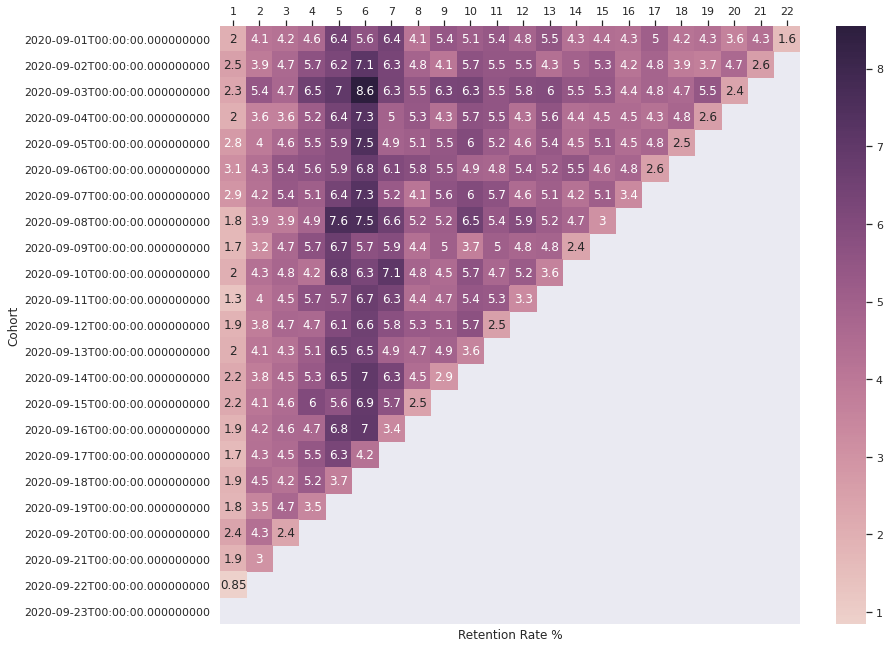

In [47]:
# строем обычную тепловую карту с помощью seaborn, удобную для представления в презентациях и gitlab
ax = sns.heatmap(result.iloc[:, 1:], cmap=sns.cubehelix_palette(as_cmap=True), annot=True)
ax.set(xlabel="Retention Rate %", ylabel="Cohort")
ax.xaxis.tick_top()

**Скорректировано:** добавлена документация к функции с помощью докстринга

In [48]:
# объединим всю работу в окончательную функцию, создадим поля start_date и end_date для произвольных интервалов
def retention_builder(df, start_date, end_date):
    '''На вход: фрейм с пользователями (дата регистрации + дата входа + id), даты начала и конца периода в строчном виде и формате год-месяц-день, на выход: сводная таблицу RR и визуализация тепловой карты для наглядного анализа'''
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    df = df[(df["reg_day"] >= start_date) & (df["auth_day"] <= end_date)]
    df["days_after_reg"] = (df.auth_day - df.reg_day).dt.days
    df_grouped = df.groupby(["reg_day", "days_after_reg"], as_index=False) \
                    .agg({"uid" : "nunique"}).rename(columns = {"uid" : "users_count"})
    df_pivot_table = df_grouped.pivot(index='reg_day', columns='days_after_reg', values='users_count')
    result = (df_pivot_table.divide(df_pivot_table[0], axis=0) * 100).round(2)
    
    # блок не виден на gitlab !!!
    
    fig = px.imshow(result.iloc[:, 1:].fillna(0),
                labels=dict(x="Day after registation", y="Cohort", color="Retention Rate"),
                x=result.columns[1:],
                y=result.index
               )
    fig.update_xaxes(side="top")
    fig.show()
    
    ax = sns.heatmap(result.iloc[:, 1:], cmap=sns.cubehelix_palette(as_cmap=True), annot=True)
    ax.set(xlabel="Retention Rate %", ylabel="Cohort")
    ax.xaxis.tick_top()
    
    return result

In [49]:
retention_builder.__doc__

'На вход: фрейм с пользователями (дата регистрации + дата входа + id), даты начала и конца периода в строчном виде и формате год-месяц-день, на выход: сводная таблицу RR и визуализация тепловой карты для наглядного анализа'

days_after_reg,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
reg_day,,,,,,,,,,,,,,,
2020-08-01,100.0,1.92,4.45,4.31,5.57,5.91,7.63,6.37,4.51,6.37,4.78,5.11,5.91,4.71,4.51
2020-08-02,100.0,2.58,4.04,4.37,5.17,6.49,6.63,6.03,4.51,5.30,5.50,5.17,4.57,5.50,NaN
2020-08-03,100.0,1.72,4.30,4.03,5.56,6.15,7.54,5.29,4.96,4.89,5.36,5.09,5.62,NaN,NaN
2020-08-04,100.0,2.05,3.57,4.69,5.22,5.28,6.47,5.15,4.43,4.69,5.28,5.61,NaN,NaN,NaN
2020-08-05,100.0,2.57,3.49,4.02,5.74,5.08,7.78,6.13,4.22,4.75,4.75,NaN,NaN,NaN,NaN
2020-08-06,100.0,1.71,5.07,5.73,5.60,5.73,7.50,6.06,5.00,5.79,NaN,NaN,NaN,NaN,NaN
2020-08-07,100.0,2.17,3.09,5.26,5.32,5.98,7.16,6.18,5.12,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-08,100.0,2.43,4.79,4.20,5.45,5.45,7.22,6.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-09,100.0,2.10,3.93,4.65,5.37,7.07,6.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


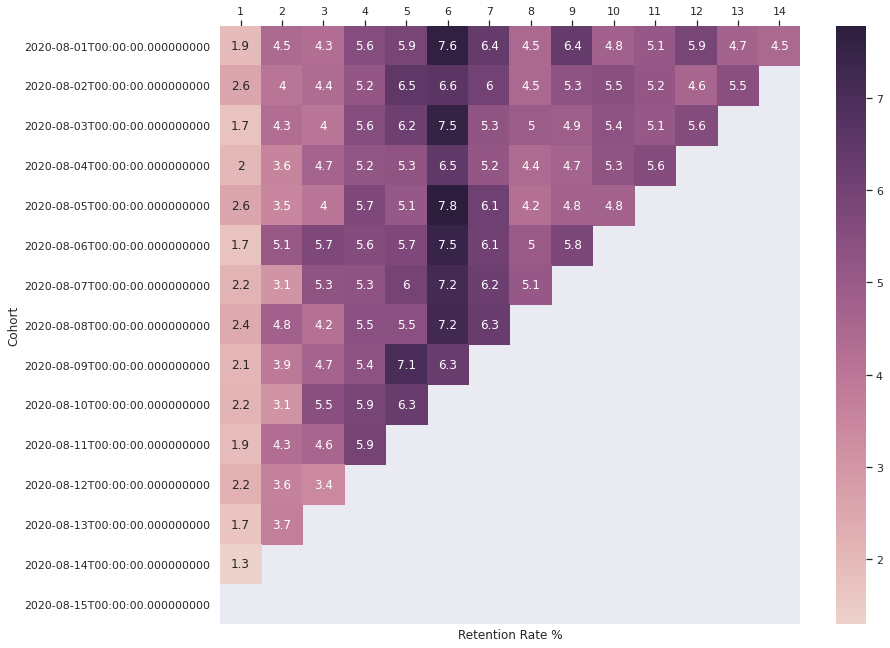

In [50]:
# произведем контрольный тест функции
retention_builder(df_players, '2020-08-01','2020-08-15')